In [1]:
import iris
import iris.plot as iplt
import numpy as np
from iris.coords import DimCoord
from iris.coord_systems import TransverseMercator,GeogCS
from iris.cube import Cube
from cf_units import Unit
import cf_units
import os
import glob
from pyproj import Proj, transform
import sys
import warnings
import multiprocessing as mp
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pyproj import Transformer

warnings.filterwarnings("ignore")

ems_hourly = ['01', '04', '06', '07', '08', '09', '10', '11', '12', '13', '15']
ems_30mins = ['bc005', 'bc006', 'bc007', 'bc009', 'bc010', 'bc011', 'bc013',  'bc015',  'bc016', 'bc017', 'bc018', 'bc012']
yrs_range = '1980_2001'


def mask_cube(cube, gb_mask):
    masked_cube_data = cube * gb_mask[np.newaxis, :, :]

    # APPLY THE MASK
    reshaped_mask = np.tile(gb_mask, (cube.shape[0], 1, 1))
    reshaped_mask = reshaped_mask.astype(int)
    reversed_array = ~reshaped_mask.astype(bool)

    # Mask the cube
    masked_cube = iris.util.mask_cube(cube, reversed_array)
    
    return masked_cube

### Get the mask
gb_mask_2km = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_2.2km_GB_Mask.npy")
gb_mask_2km_bng = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_2.2km_bng_GB_Mask.npy")
gb_mask_12km_wgs84 = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_wgs84_GB_Mask.npy")
gb_mask_12km = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_GB_Mask.npy")
gb_mask_nimrod = np.load('/nfs/a319/gy17m2a/PhD/datadir/nimrod_1km_GB_Mask_[1100,200].npy')

### 2.2km data

In [8]:
##########################################################################################
#########################################################################################
# Define variables and set up environment
##########################################################################################
##########################################################################################
root_fp = "/nfs/a319/gy17m2a/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, root_fp + 'PhD/Scripts/DataProcessing/Regridding')
from Regridding_functions import *
# Create path to files containing functions
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

gb_gdf = create_gb_outline({'init' :'epsg:3857'})

# Load UKCP18 12km model data to use in regriddding
file_model_12km=f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/12km/01/pr_rcp85_land-rcm_uk_12km_01_day_19801201-19901130.nc'
cube_12km=iris.load_cube(file_model_12km)

file_model_2_2km ='/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km/01/1980_2001/pr_rcp85_land-cpm_uk_2.2km_01_1hr_19910601-19910630.nc'
cube_2km =iris.load_cube(file_model_2_2km)

# remove ensemble member dimension
cube_2km = cube_2km[0,:,:,:]
cube_12km = cube_12km[0,:,:,:]

yrs_range = '1980_2001'
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

In [10]:
cube_2km = trim_to_bbox_of_region_regriddedobs(cube_2km, gb_gdf)
cube_2km_bng, lats_bng, lons_bng = convert_rotatedpol_to_bng(cube_2km.copy())

### Land sea mask

In [11]:
lsm = iris.load("/nfs/a319/gy17m2a/PhD/datadir/lsm_land-cpm_BI_5km.nc")[0]
lsm_2km = lsm.regrid(cube_2km_bng, iris.analysis.AreaWeighted(mdtol=0.9)) 
lsm_2km = lsm.regrid(cube_2km_bng, iris.analysis.Nearest()) 

broadcasted_lsm_2km_data = np.broadcast_to(lsm_2km.data.data, cube_2km_bng.shape)
broadcasted_lsm_2km_int = broadcasted_lsm_2km_data.astype(int)
broadcasted_lsm_2km_data_reversed = ~broadcasted_lsm_2km_data.astype(bool)

## Transform to BNG, mask with LSM and then regrid to 12km

In [15]:
# # Convert to BNG
cube_2km_bng, lats_bng, lons_bng = convert_rotatedpol_to_bng(cube_2km.copy())
# # Mask out the sea
cube_2km_bng_masked = iris.util.mask_cube(cube_2km_bng.copy(), broadcasted_lsm_2km_data_reversed)
# # Regrid to 12km
cube_2km_bng_masked_regridded_12km = cube_2km_bng_masked.regrid(cube_12km, iris.analysis.AreaWeighted(mdtol=0.8)) 

iris.save(cube_2km_bng_masked, '/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km_bng/01/1980_2001/bng_pr_rcp85_land-cpm_uk_2.2km_01_1hr_19910601-19910630.nc')



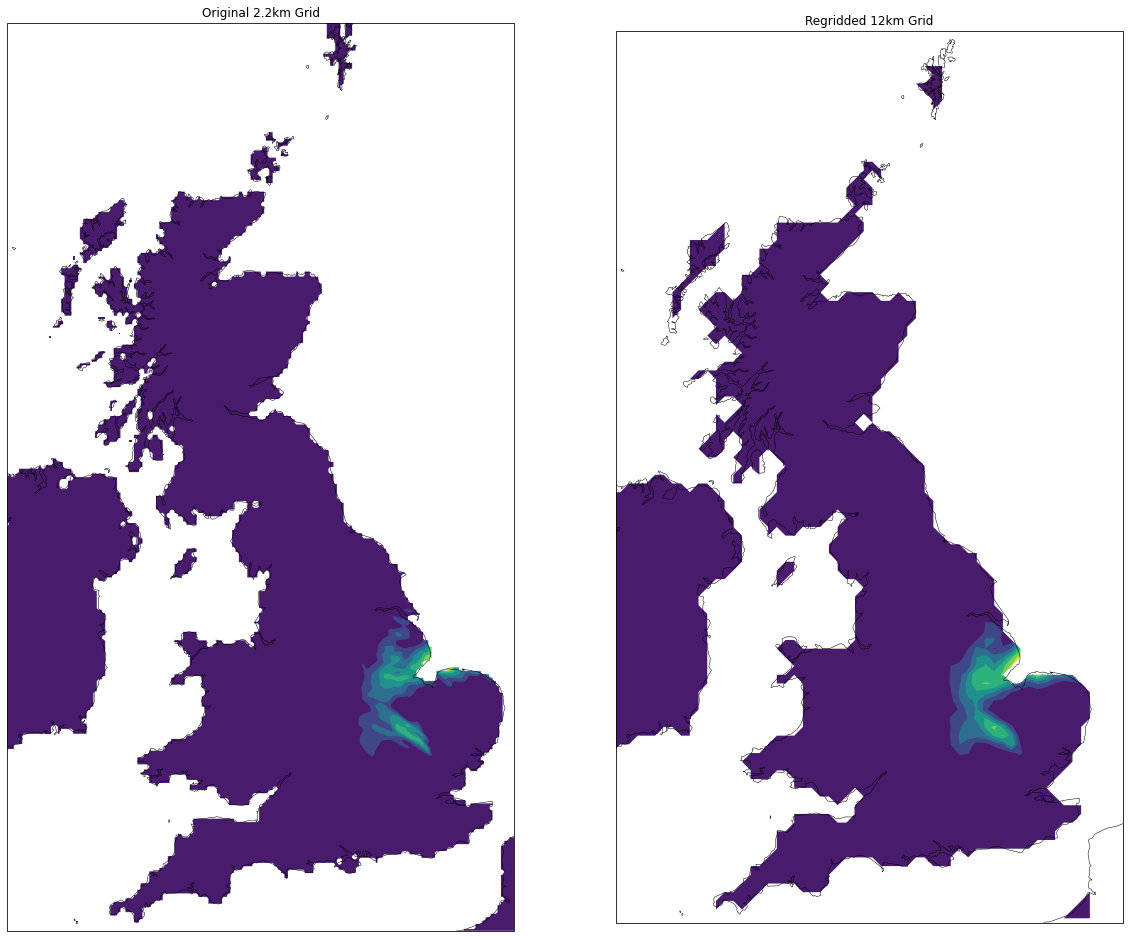

In [21]:
# Assuming cube_2km_bng_masked and cube_2km_bng_masked_regridded_12km are already defined
fig, ax = plt.subplots(ncols=2, figsize=(20, 20), subplot_kw={'projection': ccrs.OSGB()})  # Use a Cartopy projection

# Plot the first dataset
plt.sca(ax[0])  # Set the current axis to the first subplot
contour1 = iplt.contourf(cube_2km_bng_masked[10], axes=ax[0], cmap='viridis')
ax[0].coastlines(resolution='10m', color='black', linewidth=0.5)
ax[0].set_title('Original 2.2km Grid')
ax[0].grid('false')

# Plot the second dataset
plt.sca(ax[1])  # Set the current axis to the second subplot
contour2 = iplt.contourf(cube_2km_bng_masked_regridded_12km[10], axes=ax[1], cmap='viridis')
ax[1].coastlines(resolution='10m', color='black', linewidth=0.5)
ax[1].set_title('Regridded 12km Grid')
ax[1].grid('false')

# # Plot the second dataset
# plt.sca(ax[2])  # Set the current axis to the second subplot
# contour2 = iplt.contourf(cube_2km_bng_masked_regridded_12km_mdto8[10], axes=ax[2], cmap='viridis')
# ax[2].coastlines(resolution='10m', color='black', linewidth=0.5)
# ax[2].set_title('Regridded 12km Grid (masked again)')
# ax[2].grid('false')
# plt.show()
fig.savefig('/nfs/a319/gy17m2a/PhD/Scripts/DataProcessing/Regridding/Figs/fig.jpg', bbox_inches= 'tight')

### Check plotting by coast

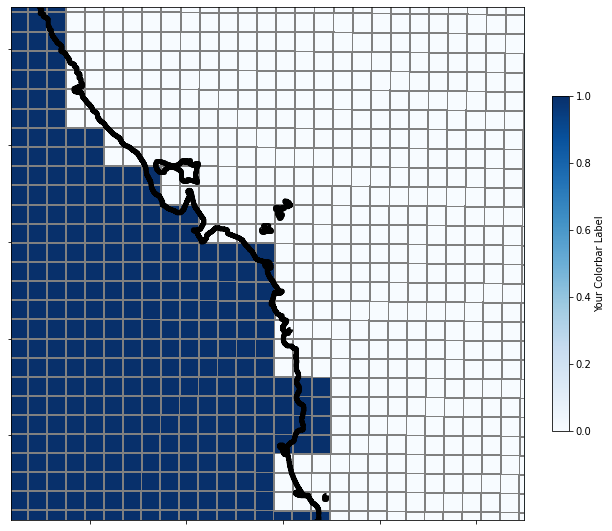

In [14]:
sys.path.insert(0, root_fp + 'PhD/Scripts/FindIndependentRainfallEvents')
from Identify_Events_Functions import *

# Get cube containing one hour worth of data
# hour_uk_cube = cube_2km_bng_masked[1,:,:]
hour_uk_cube = lsm_2km

# Set the dummy data back on the cube
# hour_uk_cube.data = test_data
rain_gauge_lat, rain_gauge_lon = 55.580322, -1.646155
# Find cornerpoint coordinates (for use in plotting)
lats_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[0]
lons_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[1]

# Trim the data timeslice to be the same dimensions as the corner coordinates
hour_uk_cube = hour_uk_cube[1:,1:]
test_data = hour_uk_cube.data

# Create location in web mercator for plotting
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
lon_rain_gauge_wm, lat_rain_gauge_wm = transformer.transform(rain_gauge_lon,rain_gauge_lat)

# Create bounding box to centre the map on
min_lat, max_lat, min_lon, max_lon = calculate_bounding_box(rain_gauge_lat, rain_gauge_lon, distance_km =30)
gdf_bbox = create_geodataframe_from_bbox(min_lat, max_lat, min_lon, max_lon)
gdf_bbox_web_mercator = gdf_bbox.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the map
extent = tilemapbase.extent_from_frame(gdf_bbox_web_mercator)
plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=1000)
plotter.plot(ax)

# Plot the data
pcmesh = ax.pcolormesh(lons_cornerpoints, lats_cornerpoints, test_data,
                       linewidths=0.1, alpha=1, cmap='Blues', edgecolors='grey')

# Hide x and y axis labels
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

# Plot the rain gauge location
plt.plot(lon_rain_gauge_wm, lat_rain_gauge_wm, 'o', color='black', markersize=10)

# Plot the GeoDataFrame
gb_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=5)

# Add a colorbar
cbar = plt.colorbar(pcmesh, ax=ax, orientation='vertical', fraction=0.03)
cbar.set_label('Your Colorbar Label')

plt.show()
